# Transfer Learning: Stand on the Shoulder of Giants

-- Created by Miya Wang. 8/21/2017

**Data:** https://cs.stanford.edu/~acoates/stl10/

**An Ensemble Model of:** 
* Xception
* VGG19
* InceptionV3
* MobileNet
* Resnet

**Training Data:** 4000 images

**Validation Data:** 1000 images

**Testing Data:** 8000 images

**Class:**10

**Ensemble Accuracy:**

**Something to Improve:** Tune hyperparameters for each single model

In [1]:
import tarfile
import numpy as np
import scipy
from matplotlib import pylab as plt
import os
from sklearn.metrics import accuracy_score
import pandas as pd

%matplotlib inline

from keras import applications
from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, Conv2D,GlobalAveragePooling2D,MaxPooling2D ,Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import regularizers

Using TensorFlow backend.


In [2]:
if not os.path.exists('./data/stl10_binary'):
    tarfile.open("data/stl10_binary.tar.gz").extractall('./data')
    
temp_f = [f for f in os.listdir("./data/stl10_binary")]
print(temp_f)

['class_names.txt', 'fold_indices.txt', 'test_X.bin', 'test_y.bin', 'train_X.bin', 'train_y.bin', 'unlabeled_X.bin']


In [3]:
## class dictionary
with open('./data/stl10_binary/class_names.txt') as f:
    class_names = f.read().strip().split('\n')

label_dict = dict(zip(range(1,11),class_names))

## Prepare Data

In [4]:
HEIGHT = 96 ##image size: 96 * 96 pixel
WIDTH = 96
DEPTH = 3

TEST_CNT = 8000
TRAIN_CNT = 5000

#DATA_DIR: './data/stl10_binary'

f = np.fromfile('./data/stl10_binary/test_X.bin', dtype=np.uint8, count=-1)
test_X = np.reshape(f, (TEST_CNT,DEPTH, WIDTH, HEIGHT))
f = np.fromfile('./data/stl10_binary/test_Y.bin', dtype=np.uint8, count=-1)
test_Y = np.reshape(f, (TEST_CNT,1))
f = np.fromfile('./data/stl10_binary/train_X.bin', dtype=np.uint8, count=-1)
train_X = np.reshape(f, (TRAIN_CNT,DEPTH, WIDTH, HEIGHT))
f = np.fromfile('./data/stl10_binary/train_Y.bin', dtype=np.uint8, count=-1)
train_Y = np.reshape(f, (TRAIN_CNT,1))

print('training data contain %d labeled images' %len(train_X))
print('test data contain %d labeled images' %len(test_X))

training data contain 5000 labeled images
test data contain 8000 labeled images


In [5]:
## one hot encoding for y

encoder = LabelEncoder()
encoder.fit(train_Y)
train_y = np_utils.to_categorical(encoder.transform(train_Y))
test_y = np_utils.to_categorical(encoder.transform(test_Y))

C:\Users\Miya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Miya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Visualization

* some pics are tricy.

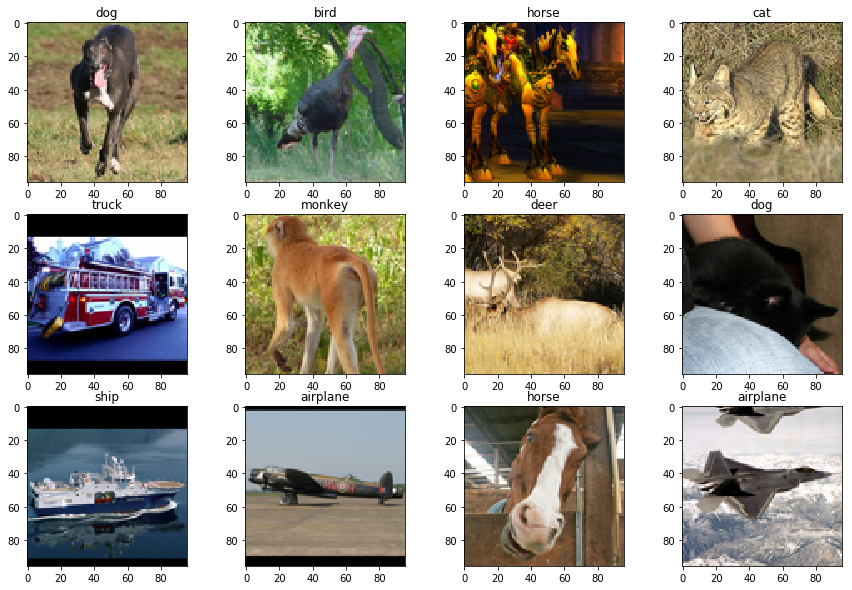

In [11]:
## visualize 12 images

M = 4
N = 3
i = 1
plt.subplots(figsize = (15,10),nrows=N, ncols=M)
for i in range(1,M*N+1):
    plt.subplot(N,M,i)
    plt.imshow(np.transpose(train_X[i],(2,1,0)))
    plt.title(label_dict[train_Y[i][0]])
    i+=1

* training, testing and validation set share similiar distribution
* dog & cat & deer;  car & truck 
* ship and airplane have unique distribution

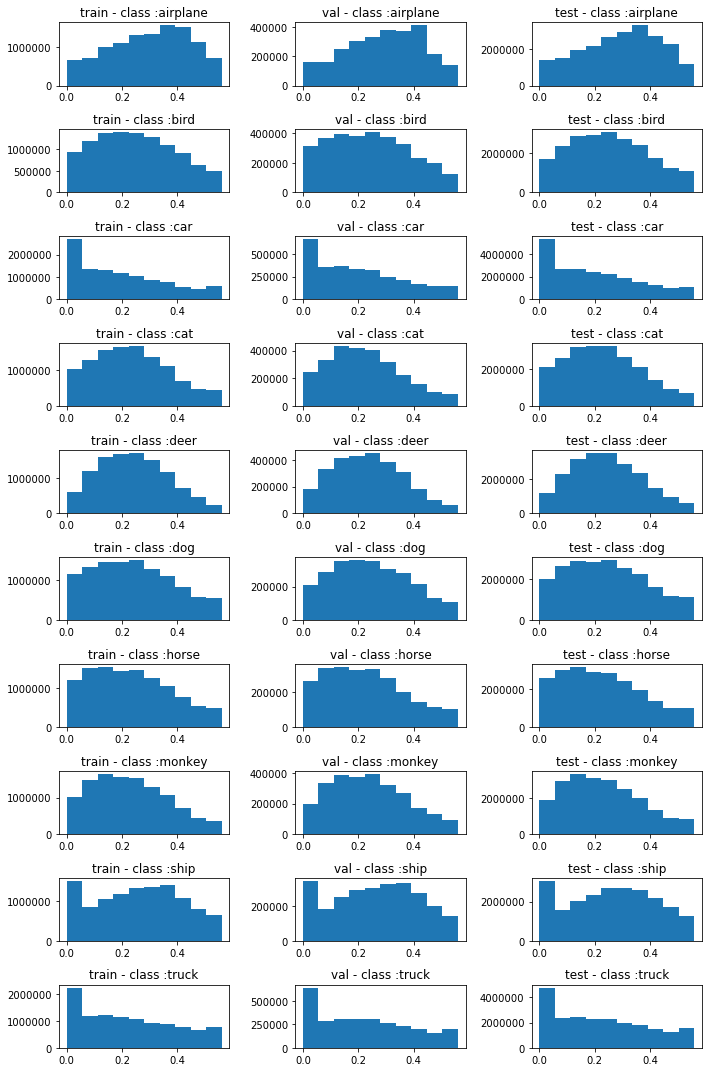

In [23]:
## training, validation, testing data distribution

divide = 4000
x_train = train_X[:divide]/455
y_train = train_Y[:divide]
x_val = train_X[divide:]/455
y_val = train_Y[divide:]
x_test = test_X/455
y_test = test_Y

N = 10
M = 3
class_no = 1
fig, axes = plt.subplots(figsize = (10,15),nrows=N, ncols=M)
for i in range(1,N*M+1):
    if i%3 ==1:
        plt.subplot(N,M,i)
        temt_train = x_train[np.asarray([y_train==class_no]).flatten()]
        plt.hist(temt_train.reshape(temt_train.shape[0]*temt_train.shape[1]*temt_train.shape[2]*temt_train.shape[3],1))
        plt.title('train - class :%s'%label_dict[class_no])
    if i%3 ==2:
        plt.subplot(N,M,i)
        temt_val = x_val[np.asarray([y_val==class_no]).flatten()]
        plt.hist(temt_val.reshape(temt_val.shape[0]*temt_val.shape[1]*temt_val.shape[2]*temt_val.shape[3],1))
        plt.title('val - class :%s'%label_dict[class_no])
    if i%3 ==0:
        plt.subplot(N,M,i)
        temt_test = x_test[np.asarray([y_test==class_no]).flatten()]
        plt.hist(temt_test.reshape(temt_test.shape[0]*temt_test.shape[1]*temt_test.shape[2]*temt_test.shape[3],1))
        plt.title('test - class :%s'%label_dict[class_no])
        class_no += 1
fig.tight_layout()

# Model

In [15]:
# rescale 
def enlarge_image(X,pixel):
    return np.array([scipy.misc.imresize(X[i], (pixel, pixel, 3)) 
                            for i in range(0, len(X))]).astype('float32')

# data_aug
def data_aug():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.15,
        horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    return train_datagen, test_datagen


## generate feed features from pre-trained model for bottleneck model 

## Input:    train_X; test_X; model type: VGG19, Xception,InceptionV3, MobileNet, Resnet; step:"train"/"test"
## Output:   feed features

def bottleneck_feed(model_type,train_X,test_X,train_y, step = "train"):
    
    train_datagen, test_datagen = data_aug()
    
    file = model_type+step+'_aug.npz'
    
    if step  == 'train':
        X_enlarge = enlarge_image(train_X,139)
    else: 
        X_enlarge = enlarge_image(test_X,139)
        
    
    if os.path.exists(file):
        print('load feed train features for bottleneck model from file')
        feed = np.load(file)['features']
        
    elif model_type == "VGG19":
        base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape = (139, 139, 3))
        base_model_input = applications.vgg16.preprocess_input(X_enlarge)
        print('base model input processed')
        
        feed = base_model.predict_generator(generator = train_datagen.flow(x = base_model_input, 
                                                                           y = train_y, 
                                                                           shuffle = False,
                                                                           batch_size = 100),
                                            steps = 45) #4500/100
        feed = np.squeeze(feed)
        np.savez(file, features = feed)
        print('bottleneck train features saved') 
        
    elif model_type == "Xception":
        base_model = applications.xception.Xception(include_top = False, 
                                               weights='imagenet',input_shape = (139, 139, 3))
        base_model_input = applications.xception.preprocess_input(X_enlarge)
        print('base model input processed')

        feed = base_model.predict_generator(generator = train_datagen.flow(x = base_model_input, 
                                                                           y = train_y, 
                                                                           shuffle = False,
                                                                           batch_size = 100),
                                            steps = 45) #4500/100
        feed = np.squeeze(feed)
        np.savez(file, features = feed)
        print('bottleneck train features saved') 
        
    elif model_type == "InceptionV3":
        base_model = applications.inception_v3.InceptionV3(include_top = False, 
                                               weights='imagenet',input_shape = (139, 139, 3))
        base_model_input = applications.inception_v3.preprocess_input(X_enlarge)
        print('base model input processed')

        feed = base_model.predict_generator(generator = train_datagen.flow(x = base_model_input, 
                                                                           y = train_y, 
                                                                           shuffle = False,
                                                                           batch_size = 100),
                                            steps = 45) #4500/100
        feed = np.squeeze(feed)
        np.savez(file, features = feed)
        print('bottleneck train features saved') 
        
    elif model_type == "MobileNet":
        base_model = applications.mobilenet.MobileNet(include_top = False, 
                                               weights='imagenet')
        X_enlarge = enlarge_image(test_X,224)        
        base_model_input = applications.mobilenet.preprocess_input(X_enlarge)
        print('base model input processed')
        
        feed = base_model.predict_generator(generator = train_datagen.flow(x = base_model_input, 
                                                                           y = train_y, 
                                                                           shuffle = False,
                                                                           batch_size = 100),
                                            steps = 45) #4500/100
        feed = np.squeeze(feed)
        np.savez(file, features = feed)
        print('bottleneck train features saved')

    elif model_type == "ResNet50":
        base_model = applications.resnet50.ResNet50(include_top = False, 
                                               weights='imagenet')
        X_enlarge = enlarge_image(test_X,197)
        base_model_input = applications.mobilenet.preprocess_input(X_enlarge)
        print('base model input processed')
        
        feed = base_model.predict_generator(generator = train_datagen.flow(x = base_model_input, 
                                                                           y = train_y, 
                                                                           shuffle = False,
                                                                           batch_size = 100),
                                            steps = 45) #4500/100
        feed = np.squeeze(feed)
        np.savez(file, features = feed)
        print('bottleneck train features saved') 
        
    return feed

In [16]:
## Build bottleneck model structure

def bottleneck_model_structure():
    model = Sequential()
    model.add(Conv2D(150, (2,2), input_shape=feed.shape[1:],kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', 
                    kernel_initializer= 'lecun_uniform',
                    W_regularizer=regularizers.l1(0.008)))
    model.add(Dense(10, activation='softmax', 
                    kernel_initializer='lecun_uniform'))
    
    return model


## Train bottleneck structure by feed features

## Input: feed features, model type: VGG19, Xception,InceptionV3,MobileNet, Resnet; label: train_y
## Output: write model

def bottleneck_model_train(model_type,train_y):
    
    feed = bottleneck_feed(model_type,train_X,test_X,train_y, step = "train")
    
    model = bottleneck_model_structure()
    
    sgd = SGD(lr=0.005, momentum=0.9,decay=0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    filepath = model_type + '_best.hdf5'
    checkpointer = ModelCheckpoint(filepath=filepath, 
                               verbose=2, save_best_only=True)
    
    history = model.fit(feed, train_y, batch_size=90, epochs=50,
              validation_split=0.2, callbacks=[checkpointer],verbose=2, shuffle=True)
    
    return history

In [17]:
def plot_history(model_type):
    history = bottleneck_model_train(model_type,train_y)
    
    print('%s'%model_type)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
## Predict using bottleneck model

## Input: model type: VGG19, Xception,InceptionV3, MobileNet, Resnet; train_X, test_X
## Output: write predicttions and print accuracy

def bottleneck_model_train_pred(model_type,train_X,test_X,train_y):
    file_model = model_type + '_best_aug.hdf5'
    
    file_feed_test = model_type+'test_aug.npz'
    
    if os.path.exists(file_feed_test):
        print('load feed test features from file')
        feed_test = np.load(file_feed_test)['features']
    else:
        feed_test = bottleneck_feed(model_type,train_X,test_X,train_y, step = "test")
    
    if os.path.exists(file_model):
        print('load trained model from file')
        
        model = bottleneck_model_structure()
        model.load_weights(file_model)
        
        sgd = SGD(lr=0.005, momentum=0.9,decay=0, nesterov=False)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
        
    else:
        print('model not trained. Train now.')
        bottleneck_model_train(model_type,train_y)
    
    pred = model.predict(feed_test)
    
    filename = model_type+'pred_aug.npz'
    
    ## save predictions
    np.savez(filename, pred)
    
    return pred 

In [20]:
def evaluate_and_compare(label_dict):
    
    models =["VGG19", "Xception","InceptionV3",'MobileNet','ResNet50']
    dict_pred = dict()
    target_names = label_dict.values
    
    for m in models:
        pred = bottleneck_model_train_pred(m,train_X,test_X,train_y)  
        y_pred = pd.DataFrame(pred).idxmax(1).values # to one dimension
        dict_pred[m] = y_pred
        y_true = pd.DataFrame(test_y).idxmax(1).values # to one dimension
        accuracy_score = accuracy_score(y_true, y_pred)
        print('%s accuracy on test data'%(m,accuracy_score))
        print(classification_report(y_true, y_pred, target_names=target_names))
          
    return dict_pred

In [ ]:
def ensemble(label_dict):
    dict_pred = evaluate_and_compare(label_dict)
    
    

In [ ]:
## create training feed for bottleneck model from five pre-trained models

for m in ["VGG19", "Xception","InceptionV3",'MobileNet','ResNet50']:
    for s in ['train','test']:
        bottleneck_feed(m,train_X,test_X,train_y, s)

load feed train features for base model from file
load feed train features for base model from file
load feed train features for base model from file
load feed train features for base model from file
load feed train features for base model from file
load feed train features for base model from file
load feed train features for base model from file
load feed train features for base model from file
base model input processed
bottleneck train features saved
base model input processed


In [ ]:
## Train and visualize

for m in ["VGG19", "Xception","InceptionV3",'MobileNet','ResNet50']:
    history = bottleneck_model_train(model_type,train_y)
    plot_history(model_type)  

In [ ]:
## evaluate and summarize performance

dict_pred = evaluate_and_compare(label_dict)

In [353]:
feed = bottleneck_feed('Xception',train_X,test_X,step = "train")
bottleneck_model_train(feed, model_type="Xception")

load feed train features for base model from file


C:\Users\Miya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_initializer="lecun_uniform", kernel_regularizer=<keras.reg...)`
  


Train on 4000 samples, validate on 1000 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 111.48841, saving model to Xception_best.hdf5
17s - loss: 148.0541 - acc: 0.6225 - val_loss: 111.4884 - val_acc: 0.7020
Epoch 2/50
Epoch 00001: val_loss improved from 111.48841 to 52.43038, saving model to Xception_best.hdf5
14s - loss: 80.8489 - acc: 0.8195 - val_loss: 52.4304 - val_acc: 0.7650
Epoch 3/50
Epoch 00002: val_loss improved from 52.43038 to 16.05566, saving model to Xception_best.hdf5
13s - loss: 32.6295 - acc: 0.8600 - val_loss: 16.0557 - val_acc: 0.7580
Epoch 4/50
Epoch 00003: val_loss improved from 16.05566 to 2.83192, saving model to Xception_best.hdf5
13s - loss: 7.2528 - acc: 0.8555 - val_loss: 2.8319 - val_acc: 0.6830
Epoch 5/50
Epoch 00004: val_loss improved from 2.83192 to 1.75583, saving model to Xception_best.hdf5
13s - loss: 1.7466 - acc: 0.8420 - val_loss: 1.7558 - val_acc: 0.7520
Epoch 6/50
Epoch 00005: val_loss improved from 1.75583 to 1.63061, saving model 

KeyboardInterrupt: 